In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to Generative Adversarial Networks (GANs)

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture.

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN.



# 生成对抗网络（GANs）介绍

在这个笔记本中，你将从头开始构建一个GAN，大致遵循DCGAN架构。

**目标：**

1. 从头开始构建一个GAN架构
2. 编写GAN损失函数并从头开始训练GAN
3. 体验训练GAN时固有的一些不稳定性问题
4. [Bonus] 将无条件GAN扩展为条件GAN。


## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [ ]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                  transforms.ToTensor(),
                  transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.12MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataloader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

In [ ]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

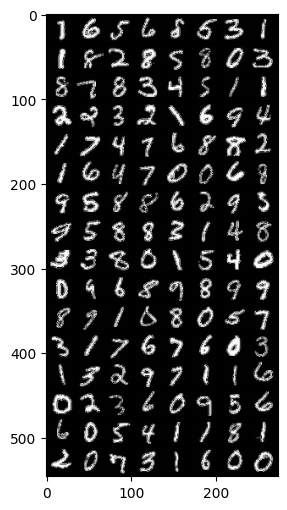

In [ ]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm
- ReLU

## 2. 模型架构

我们将遵循 DCGAN（深度卷积生成对抗网络）的通用架构。DCGAN 的这篇[影响深远的论文](https://arxiv.org/pdf/1511.06434v2.pdf)为现代 GAN 的基础和训练方法奠定了许多理论。

（GAN 的训练以**困难**著称，在本笔记中我们将尝试理解其中原因。）

完成 `get_upscaling_block` 函数后，使用该函数定义我们的模型，具体如下：

### 输入和输出：

- **输入**：随机噪声 \( z \)，形状为 `[n_batch, n_z]`  
- **输出**：生成的图像大小为 `[n_batch, 1, 32, 32]`，值范围为 [-1, 1]


### 步骤：

1. **重塑 z**：将 \( z \) 变换为 `[n_batch, n_z, 1, 1]`，将其视为“图像”。
2. **第一个上采样块**：输出形状为 `[n_batch, ngf*4, 4, 4]`。
3. **第二个上采样块**：输出形状为 `[n_batch, ngf*2, 8, 8]`。
4. **第三个上采样块**：输出形状为 `[n_batch, ngf, 16, 16]`。
5. **第四个（最后一个）上采样块**：输出形状为 `[n_batch, 1, 32, 32]`。




## 2.1. 生成器

生成器通过连续的上采样块，将形状为 `[batch_size, latent_size]` 的潜在向量转换为图像（像素值范围在 [-1, 1]）。

生成器模块包含以下部分：
- 转置卷积（Transpose Convolution）  
- 批归一化（Batch Norm）  
- ReLU 激活函数

In [ ]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias=False),
            nn.Tanh()
        )
    else:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(channels_out),
            nn.ReLU()
        )




class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #

        self.model = nn.Sequential(
            get_upscaling_block(nz, ngf*4, 4, 1, 0),
            get_upscaling_block(ngf*4, ngf*2, 4, 2, 1),
            get_upscaling_block(ngf*2, ngf, 4, 2, 1),
            get_upscaling_block(ngf, nchannels, 4, 2, 1, True)
        )

        ###################

    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)


### 2.1.3. Sanity Tests

### 2.1.3. 合理性测试（Sanity Tests）

In [ ]:
nz = 1000
z = torch.randn(batch_size, nz)

In [ ]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

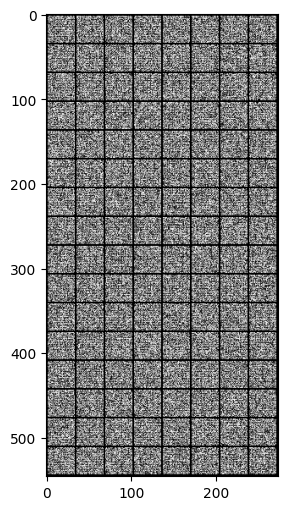

In [ ]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator.

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]`

## 2.2. 判别器

判别器将是生成器的镜像。
  
判别器也将使用全卷积架构，每个块由以下部分组成：
- 卷积层（Conv layer）
- 批归一化（BatchNorm）
- ReLU 激活函数（ReLU）

完成 `get_downscaling_block` 函数，然后使用它来定义判别器的以下架构：

输入：形状为 `[n_batch, 1, 32, 32]` 的图像（范围在 [-1, 1] 之间）  
输出：判别器分数 `[n_batch, 1]`，范围在 [0, 1] 之间

1. 第一个下采样块 → `[n_batch, ndf, 16, 16]`
2. 第二个下采样块 → `[n_batch, ndf*2, 8, 8]`
3. 第三个下采样块 → `[n_batch, ndf*4, 4, 4]`
4. 最后一个下采样块 → `[n_batch, 1]`

In [ ]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):

    if is_last:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias=False),
            nn.Sigmoid()
        )

    elif not use_batch_norm:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias=False),
            nn.LeakyReLU(0.2)
        )

    else:
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias=False),
            nn.BatchNorm2d(channels_out,),
            nn.LeakyReLU(0.2)
        )




class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()

        ###################
        #                 #
        # YOUR CODE HERE  #

        self.model = nn.Sequential(
            get_downscaling_block(nchannels, ndf, 4, 2, 1),
            get_downscaling_block(ndf, ndf*2, 4, 2, 1),
            get_downscaling_block(ndf*2, ndf*4, 4, 2, 1),
            get_downscaling_block(ndf*4, 1, 4, 1, 0, is_last=True)
        )

        #                 #
        ###################

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

### 2.2.3 合理性测试



In [ ]:
real_batch, real_labels = next(iter(dataloader))

In [ ]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



# 3. 训练

## 3.1 损失
需要记住的关键是，逻辑损失和非饱和逻辑GAN损失可以仅通过使用[二元交叉熵损失](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)来表示。我们的GAN损失将仅使用以下标准定义：

In [ ]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions.
1. First, we need to continuously sample z from a Gaussian distribution.
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s.

## 3.2 辅助函数

我们将需要几个辅助函数。
1. 首先，我们需要不断地从高斯分布中采样 z。
2. 其次，我们需要在使用BCE损失时生成“真实标签”。这应该输出由0和1组成的向量。

In [ ]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

## 3.3 创建优化器和超参数

原始的DCGAN论文显示，Adam优化器在生成器和判别器中表现良好，学习率为0.0002，Beta1 = 0.5。

定义你的优化器。

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training!
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve.
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

## 3.3 训练！

现在进入有趣的部分，训练！

训练一个GAN包括先更新判别器，然后更新生成器。  
训练GAN需要**耐心**！记住，训练GAN时很多事情可能会出错：
- 判别器对于生成器来说太强 - 生成器无法进步。
- 生成器轻易地欺骗了判别器 - 生成器无法学习。
- 模式崩溃 - 生成器无法生成多样化的图像。

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

## 3.4 Going Further

- ### Modify $ngf$ or $ndf$.

In [ ]:
# 显著增大 ngf
nz = 100
ngf = 128
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

In [ ]:
# 显著增大 ndf
nz = 100
ngf = 32
ndf = 128

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Replace the custom weight initialization with pytorch’s default initialization.


In [ ]:
# 使用 Pytorch 默认初始化
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

# netD.apply(weights_init)
# netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Replace the training loss of the generation with the “true” loss derived from the original equation.

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 10

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(1 - yhat_fake, get_labels_zero(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Change the learning rate of one or both models.

同时增大 $lr_d = 0.002$ 和 $lr_g = 0.005$

In [ ]:
# 同时增大 lr_d=0.002 和 lr_g=0.005
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.002
lr_g = 0.005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

同时增大 $lr_d = 0.0004$ 和 $lr_g = 0.001$

In [ ]:
# 同时增大 lr_d=0.0004 和 lr_g=0.001
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.00002
lr_g = 0.00005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

同时减小 $lr_d = 0.00002$ 和 $lr_g = 0.00005$

In [ ]:
# 同时减小 lr_d=0.00002 和 lr_g=0.00005
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.00002
lr_g = 0.00005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 10

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

增大 $lr_d = 0.0005$ 与 $lr_g$ 相等

In [ ]:
# 增加 lr_d=0.0005
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0005
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

减小 $lr_g = 0.0002$ 与 $lr_d$ 相等

In [ ]:
# 减小 lr_g=0.0002
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0002
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Learn for longer (ex : 30 epochs).

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
# nb_epoch 增加到 30
nb_epochs = 30

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Reduce or increase significantly $n_z$ (ex : $n_z = 10$ ou $1000$).


$n_z = 10$

In [ ]:
# n_z = 10
nz = 10
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

$n_z=1000$

In [ ]:
# n_z = 1000
nz = 1000
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Using a learned GAN, take 2 noise vectors $z_1$ and $z_2$ and generate the images.

In [ ]:
# 以默认超参数训练一个 GAN
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

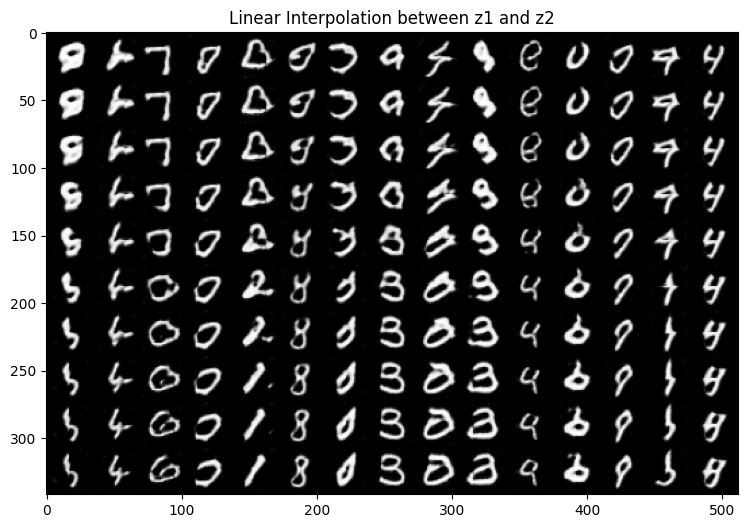

In [ ]:
n_ex = 15

# 生成两个噪声向量 z1 和 z2
z1 = sample_z(n_ex, nz).to(device)
z2 = sample_z(n_ex, nz).to(device)

# 生成插值图像
netG.eval()  # 使生成器进入评估模式

alpha_values = torch.linspace(0, 1, steps=10).to(device)  # 生成从 0 到 1 的 10 个插值值
generated_images = []

for alpha in alpha_values:
    # 计算线性插值的噪声向量
    z_interp = alpha * z1 + (1 - alpha) * z2

    # 使用生成器生成图像
    fake_images = netG(z_interp)

    # 反归一化，准备可视化
    un_norm = renorm(fake_images)  # 反归一化操作
    generated_images.append(un_norm)

# 将生成的图像拼成网格
grid = torchvision.utils.make_grid(torch.cat(generated_images, dim=0), nrow=n_ex)

# 将图像转化为 PIL 格式并显示
pil_grid = to_pil(grid)
plt.imshow(pil_grid)
plt.title("Linear Interpolation between z1 and z2")
plt.show()

- ### Try to generate $64 \times 64$ images by adding another block in your models (resize your real data accordingly when defining the dataloader).


In [ ]:
batch_size = 128 # Images per batch

# Resize to 64x64 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(64),
                  transforms.ToTensor(),
                  transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

dataloader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator_64(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #

        self.model = nn.Sequential(
            get_upscaling_block(nz, ngf*8, 4, 1, 0),
            get_upscaling_block(ngf*8, ngf*4, 4, 2, 1),
            get_upscaling_block(ngf*4, ngf*2, 4, 2, 1),
            get_upscaling_block(ngf*2, ngf, 4, 2, 1),
            get_upscaling_block(ngf, nchannels, 4, 2, 1, True)
        )

        ###################

    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)


In [ ]:
class Discriminator_64(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()

        ###################
        #                 #
        # YOUR CODE HERE  #

        self.model = nn.Sequential(
            get_downscaling_block(nchannels, ndf, 4, 2, 1),
            get_downscaling_block(ndf, ndf*2, 4, 2, 1),
            get_downscaling_block(ndf*2, ndf*4, 4, 2, 1),
            get_downscaling_block(ndf*4, ndf*8, 4, 2, 1),
            get_downscaling_block(ndf*8, 1, 4, 1, 0, is_last=True)
        )

        #                 #
        ###################

    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator_64(ndf, nchannels).to(device)
netG = Generator_64(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

- ### Try another dataset CIFAR-10, for example.


CIFAR-10

In [ ]:
# 使用 CIFAR-10
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                  transforms.ToTensor(),
                  transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

cifar10_train = torchvision.datasets.CIFAR10(root='.', download=True, transform=mytransform)

cifar10_dataloader = DataLoader(dataset=cifar10_train, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
nz = 100
ngf = 32
ndf = 32

nchannels= 3
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf, nchannels).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))

In [ ]:
nb_epochs = 10

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(cifar10_dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

In [ ]:
nb_epochs = 15

g_losses = []
d_losses = []


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(cifar10_dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im.detach())




        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) #     YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(fake_im)


        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) #      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

# 4. 条件GAN [Bonus]

提高训练性能和获得生成控制的一种简单方法是向生成器和判别器中提供额外的信息，这就是**条件GAN**。在这种情况下，我们将把类标签（例如MNIST的数字标签）提供给生成器和判别器。这将有助于两个网络的训练。

## 4.1 条件生成器和判别器

使用你在构建GAN时的模块（`get_upsampling_block` 和 `get_downsampling_block` 函数）来完成 **ConditionalDiscriminator** 和 **ConditionalGenerator** 类。

### 4.1.1 生成器

In [ ]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()

        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        self.rest_model = nn.Sequential(
            get_upscaling_block(ngf*16, ngf*8, 4, 2, 1),
            get_upscaling_block(ngf*8, ngf*4, 4, 2, 1),
            get_upscaling_block(ngf*4, 1, 4, 2, 1, True)
        )

        ###################

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 上采样：分别对潜在向量和标签进行处理
        x = self.upscaling_z(x)  # 对潜在向量 x 进行上采样
        y = self.upscaling_c(y)  # 对标签信息 y 进行上采样

        # 合并 x 和 y
        combined = torch.cat([x,y], dim=1)

        return self.rest_model(combined)

### 4.1.2 Discriminator

In [ ]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)

        ###################
        #                 #
        # YOUR CODE HERE  #

        self.rest = nn.Sequential(
            get_downscaling_block(ndf*4, ndf*8, 4, 2, 1),
            get_downscaling_block(ndf*8, ndf*16, 4, 2, 1),
            get_downscaling_block(ndf*16, 1, 4, 1, 0, is_last=True)
        )

        #                 #
        ###################

    def forward(self, x, y):
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        y = y.unsqueeze(2).unsqueeze(2)
        y = y.expand(-1, -1, x.size(2), x.size(3))

        # 下采样：分别对潜在向量和标签进行处理
        x = self.downscale_x(x)  # 对图像 x 进行下采样
        y = self.downscale_y(y)  # 对标签信息 y 进行下采样

        # 合并 x 和 y
        combined = torch.cat([x, y], dim=1)  # 沿着通道维度合并 x 和 y

        return self.rest(combined).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

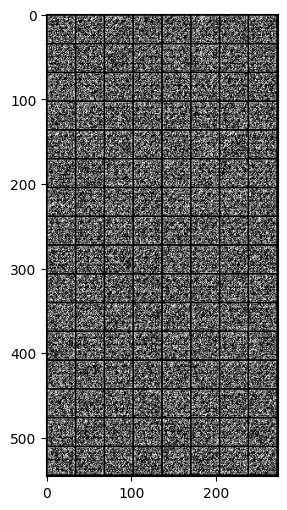

In [ ]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [ ]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [ ]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



In [ ]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):

    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)


        y = F.one_hot(labels).float().to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################

        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        im_fake = netG(z, y)

        # 3. Classify real image with D
        yhat_real = netD(im, y)

        # 4. Classify fake image with D
        yhat_fake = netD(im_fake.detach(), y)


        ###
        ### Discriminator
        ###

        d_loss = criterion(yhat_real, get_labels_one(cur_batch_size)) + criterion(yhat_fake, get_labels_zero(cur_batch_size)) # YOUR CODE HERE
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ###
        ### Generator
        ###
        yhat_fake = netD(im_fake, y)

        g_loss = criterion(yhat_fake, get_labels_one(cur_batch_size)) # YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.show()


            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1


## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

## 4.2 测试  
**可视化噪声向量 $ z $ 对生成的影响**  
同一列中的所有数字都使用相同的噪声向量 $ z $。

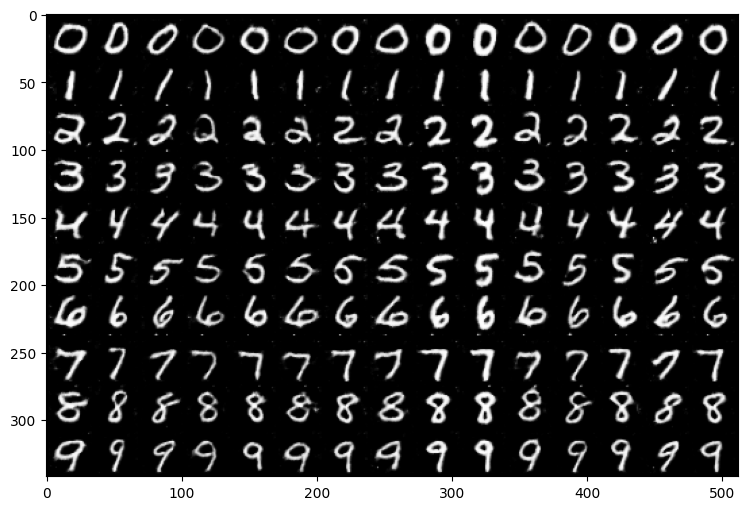

In [ ]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
